# Neural Network vs Manual Fitting: Isotopomer Analysis Comparison

This notebook compares the results of neural network-based isotopomer analysis with traditional manual fitting results.

## Data Sources
- **Manual Results**: `canmsData.xlsx` - Contains manually fitted isotopomer percentages
- **Raw Data**: `metabolabpytools/jupyter/hsqcData1.xlsx` and `gcmsData1.xlsx` - Raw HSQC and GC-MS measurements

## Metabolites Analyzed
1. Alanine (3 carbons, HSQC: [0,1,1])
2. Lactate (3 carbons, HSQC: [0,1,1])
3. Aspartate (4 carbons, HSQC: [0,1,1,0])
4. Glutamate (5 carbons, HSQC: [0,1,1,1,0])

In [5]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from metabolabpytools import isotopomerAnalysis

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully")

Libraries imported successfully


## 1. Load Manual Results from canmsData.xlsx

In [22]:
def load_manual_results(filepath='canmsData.xlsx'):
    """Load manual results from Excel file - properly handles NaN Set/Exp values"""
    manual_results = {}
    xl = pd.ExcelFile(filepath)
    
    for sheet_name in xl.sheet_names:
        df = pd.read_excel(xl, sheet_name=sheet_name)
        
        # Forward fill Set and Exp to handle NaN continuation rows
        df['Set'] = df['Set'].ffill()
        df['Exp'] = df['Exp'].ffill()
        
        # Remove rows where Isotopomer is NaN (empty rows)
        df = df[df['Isotopomer'].notna()]
        
        # Group by Set and Exp
        experiments = df.groupby(['Set', 'Exp'])
        
        manual_results[sheet_name] = {}
        for (set_num, exp_num), group in experiments:
            # Extract isotopomers and percentages
            isotopomers = []
            percentages = []
            
            for _, row in group.iterrows():
                iso = row['Isotopomer']
                pct = row['Percentages']
                if pd.notna(iso) and pd.notna(pct):
                    isotopomers.append(str(iso))
                    percentages.append(pct)
            
            manual_results[sheet_name][int(exp_num)] = {
                'isotopomers': isotopomers,
                'percentages': np.array(percentages)
            }
    
    return manual_results

# Load the manual results
manual_results = load_manual_results()

print("Manual Results Loaded:")
for metabolite, experiments in manual_results.items():
    print(f"\n{metabolite}:")
    for exp_num, data in experiments.items():
        print(f"  Experiment {exp_num}: {len(data['isotopomers'])} isotopomers")
        print(f"    Total percentage: {np.sum(data['percentages']):.2f}%")
        # Show first few isotopomers
        for i, (iso, pct) in enumerate(zip(data['isotopomers'][:5], data['percentages'][:5])):
            print(f"      {iso}: {pct:.2f}%")

Manual Results Loaded:

Alanine:
  Experiment 1: 5 isotopomers
    Total percentage: 100.00%
      0 0 0: 79.62%
      0 1 1: 16.51%
      0 0 1: 3.09%
      1 1 1: 0.10%
      0 1 0: 0.68%
  Experiment 2: 5 isotopomers
    Total percentage: 100.00%
      0 0 0: 79.62%
      0 1 1: 16.51%
      0 0 1: 3.29%
      1 1 1: 0.09%
      0 1 0: 0.48%
  Experiment 3: 5 isotopomers
    Total percentage: 100.00%
      0 0 0: 79.65%
      0 1 1: 16.57%
      0 0 1: 3.67%
      1 1 1: 0.09%
      0 1 0: 0.03%

Lactate:
  Experiment 1: 5 isotopomers
    Total percentage: 100.00%
      0 0 0: 73.20%
      0 1 1: 22.55%
      0 0 1: 3.34%
      1 1 1: 0.19%
      0 1 0: 0.72%
  Experiment 2: 5 isotopomers
    Total percentage: 100.00%
      0 0 0: 73.19%
      0 1 1: 22.53%
      0 0 1: 3.55%
      1 1 1: 0.19%
      0 1 0: 0.53%
  Experiment 3: 5 isotopomers
    Total percentage: 100.00%
      0 0 0: 73.23%
      0 1 1: 22.61%
      0 0 1: 3.99%
      1 1 1: 0.17%
      0 1 0: 0.00%

Aspartate:
  E

## 2. Define Metabolite Configurations

In [7]:
# Metabolite configurations
METABOLITES = {
    'L-Alanine': {
        'hsqc_vector': [0, 1, 1],
        'n_carbons': 3,
        'manual_name': 'Alanine',
        'model_path': 'metabolabpytools/jupyter/saved_models/model_hsqc_0_1_1.keras'
    },
    'L-LacticAcid': {
        'hsqc_vector': [0, 1, 1],
        'n_carbons': 3,
        'manual_name': 'Lactate',
        'model_path': 'metabolabpytools/jupyter/saved_models/model_hsqc_0_1_1.keras'
    },
    'L-AsparticAcid': {
        'hsqc_vector': [0, 1, 1, 0],
        'n_carbons': 4,
        'manual_name': 'Aspartate',
        'model_path': None  # Need to train
    },
    'L-GlutamicAcid': {
        'hsqc_vector': [0, 1, 1, 1, 0],
        'n_carbons': 5,
        'manual_name': 'Glutamate',
        'model_path': None  # Need to train
    }
}

# Display configurations
config_df = pd.DataFrame([
    {
        'Metabolite': name,
        'HSQC Vector': str(config['hsqc_vector']),
        'Carbons': config['n_carbons'],
        'Manual Name': config['manual_name'],
        'Model Available': 'Yes' if config['model_path'] and os.path.exists(config['model_path']) else 'No'
    }
    for name, config in METABOLITES.items()
])

print("Metabolite Configurations:")
display(config_df)

Metabolite Configurations:


,Metabolite,HSQC Vector,Carbons,Manual Name,Model Available
0,L-Alanine,"[0, 1, 1]",3,Alanine,Yes
1,L-LacticAcid,"[0, 1, 1]",3,Lactate,Yes
2,L-AsparticAcid,"[0, 1, 1, 0]",4,Aspartate,No
3,L-GlutamicAcid,"[0, 1, 1, 1, 0]",5,Glutamate,No


## 3. Run Neural Network Analysis

We'll analyze each metabolite where a trained model is available.

In [8]:
def run_nn_analysis(metabolite_name, config, hsqc_data_file, gcms_data_file):
    """
    Run neural network analysis for a metabolite
    
    Returns:
        dict with predictions, std_dev, and distributions
    """
    print(f"\n{'='*70}")
    print(f"Analyzing {metabolite_name}")
    print('='*70)
    
    hsqc_vector = config['hsqc_vector']
    n_carbons = config['n_carbons']
    model_path = config['model_path']
    
    if model_path is None:
        print(f"⚠️  No trained model available for {metabolite_name}")
        print(f"   HSQC vector: {hsqc_vector}")
        return None
    
    if not os.path.exists(model_path):
        print(f"⚠️  Model file not found: {model_path}")
        return None
    
    # Initialize NN analyzer
    ia_nn = isotopomerAnalysis.IsotopomerAnalysisNN()
    
    # Load data
    print(f"Loading HSQC and GC-MS data...")
    ia_nn.load_hsqc_and_gcms_data(hsqc_data_file, gcms_data_file)
    
    # Create feature vectors
    print(f"Creating feature vectors for {metabolite_name}...")
    ia_nn.inspect_metabolite_data(metabolite_name)
    X_real_data = ia_nn.create_feature_vectors(metabolite_name)
    
    print(f"Feature vector shape: {X_real_data.shape}")
    
    # Load model and predict
    print(f"Running initial prediction...")
    mean_predictions, std_dev_predictions, predicted_distributions = \
        ia_nn.load_model_and_predict(model_path, X_real_data, n_carbons)
    
    # Simulate and refine
    print(f"Simulating HSQC and GC-MS from predictions...")
    predicted_hsqc_data, predicted_gcms_data = \
        ia_nn.simulate_from_predictions(predicted_distributions, hsqc_vector)
    
    print(f"Refining predictions...")
    combined_vector = ia_nn.combine_hsqc_gcms(predicted_hsqc_data, predicted_gcms_data)
    mean_predictions_refined, std_dev_predictions_refined, predicted_distributions_refined = \
        ia_nn.load_model_and_predict(model_path, combined_vector, n_carbons)
    
    print(f"✓ Analysis complete")
    
    return {
        'predictions': mean_predictions_refined,
        'std_dev': std_dev_predictions_refined,
        'distributions': predicted_distributions_refined,
        'n_experiments': X_real_data.shape[0]
    }

### 3.1 Analyze Alanine

In [9]:
hsqc_data_file = 'metabolabpytools/jupyter/hsqcData1.xlsx'
gcms_data_file = 'metabolabpytools/jupyter/gcmsData1.xlsx'

# Analyze Alanine
alanine_nn_results = run_nn_analysis('L-Alanine', METABOLITES['L-Alanine'], hsqc_data_file, gcms_data_file)

if alanine_nn_results:
    print("\nAlanine NN Predictions:")
    for i, pred in enumerate(alanine_nn_results['predictions']):
        print(f"\nExperiment {i+1}:")
        print(f"  Predictions: {pred}")
        print(f"  Std Dev: {alanine_nn_results['std_dev'][i]}")
        print(f"  Total: {np.sum(pred):.2f}%")


Analyzing L-Alanine
Loading HSQC and GC-MS data...
HSQC and GC-MS data loaded successfully.
Creating feature vectors for L-Alanine...
HSQC Multiplets for L-Alanine:
Experiment 1: [[2], [2, 1], [2, 3], [2, 1, 3], [3], [3, 2]]
Experiment 2: [[2], [2, 1], [2, 3], [2, 1, 3], [3], [3, 2]]
Experiment 3: [[2], [2, 1], [2, 3], [2, 1, 3], [3], [3, 2]]

HSQC Multiplet Percentages for L-Alanine:
Experiment 1: [np.float64(6.957), np.float64(0.0), np.float64(92.319), np.float64(0.724), np.float64(17.52), np.float64(82.48)]
Experiment 2: [np.float64(6.835), np.float64(1.009), np.float64(91.896), np.float64(0.26), np.float64(18.531), np.float64(81.469)]
Experiment 3: [np.float64(5.134), np.float64(0.0), np.float64(94.133), np.float64(0.733), np.float64(17.318), np.float64(82.682)]

GC-MS Percentages for L-Alanine:
Experiment 1: [np.float64(79.59), np.float64(3.7), np.float64(16.49), np.float64(0.22)]
Experiment 2: [np.float64(79.59), np.float64(3.7), np.float64(16.49), np.float64(0.22)]
Experiment 3

/Users/robertatherton/metabolabpytools/metabolabpytools/.venv/lib/python3.13/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Mean Predictions: [[76.89714    1.7108451  1.1389072  8.126116   2.9789932  2.713203
   5.215184   1.2196436]
 [76.93756    1.7219758  1.1713636  8.081947   2.9711547  2.720185
   5.1969714  1.1989756]
 [76.84965    1.6589582  1.0856259  8.299781   2.9722095  2.6699283
   5.284955   1.1790253]]
Standard Deviation of Predictions: [[3.990779   0.9520825  1.1246146  3.4791439  0.9693818  1.218389
  1.7369748  1.6254593 ]
 [3.928392   0.9553737  1.1179588  3.4722538  0.97981066 1.2279165
  1.7371935  1.6126946 ]
 [4.092733   0.9475341  1.0922464  3.563203   0.98485017 1.207623
  1.7833775  1.60341   ]]
Simulating HSQC and GC-MS from predictions...
Refining predictions...


/Users/robertatherton/metabolabpytools/metabolabpytools/.venv/lib/python3.13/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Mean Predictions: [[75.96421    2.1950448  1.960248   6.8762484  3.0081944  3.472416
   5.154435   1.3693299]
 [75.950935   2.2034142  1.9576193  6.8665686  2.9981406  3.4991126
   5.177885   1.3464459]
 [75.856384   2.1572828  1.9161875  7.0322266  3.0103006  3.4738414
   5.2371883  1.3166995]]
Standard Deviation of Predictions: [[3.7000415  0.96595603 1.4289149  3.0293632  0.85469705 1.6610638
  1.6923299  1.6266729 ]
 [3.6742496  0.96288514 1.4504008  2.9737208  0.8472273  1.6687229
  1.7036192  1.6182432 ]
 [3.6774306  0.970837   1.4551173  3.0887754  0.8465924  1.660713
  1.6990665  1.5993106 ]]
✓ Analysis complete

Alanine NN Predictions:

Experiment 1:
  Predictions: [75.96421    2.1950448  1.960248   6.8762484  3.0081944  3.472416
  5.154435   1.3693299]
  Std Dev: [3.7000415  0.96595603 1.4289149  3.0293632  0.85469705 1.6610638
 1.6923299  1.6266729 ]
  Total: 100.00%

Experiment 2:
  Predictions: [75.950935   2.2034142  1.9576193  6.8665686  2.9981406  3.4991126
  5.177885  

### 3.2 Analyze Lactate

In [10]:
# Analyze Lactate
lactate_nn_results = run_nn_analysis('L-LacticAcid', METABOLITES['L-LacticAcid'], hsqc_data_file, gcms_data_file)

if lactate_nn_results:
    print("\nLactate NN Predictions:")
    for i, pred in enumerate(lactate_nn_results['predictions']):
        print(f"\nExperiment {i+1}:")
        print(f"  Predictions: {pred}")
        print(f"  Std Dev: {lactate_nn_results['std_dev'][i]}")
        print(f"  Total: {np.sum(pred):.2f}%")


Analyzing L-LacticAcid
Loading HSQC and GC-MS data...
HSQC and GC-MS data loaded successfully.
Creating feature vectors for L-LacticAcid...
HSQC Multiplets for L-LacticAcid:
Experiment 1: [[2], [2, 1], [2, 3], [2, 1, 3], [3], [3, 2]]
Experiment 2: [[2], [2, 1], [2, 3], [2, 1, 3], [3], [3, 2]]
Experiment 3: [[2], [2, 1], [2, 3], [2, 1, 3], [3], [3, 2]]

HSQC Multiplet Percentages for L-LacticAcid:
Experiment 1: [np.float64(5.046), np.float64(0.711), np.float64(93.668), np.float64(0.575), np.float64(14.348), np.float64(85.652)]
Experiment 2: [np.float64(5.264), np.float64(0.59), np.float64(93.359), np.float64(0.787), np.float64(15.459), np.float64(84.541)]
Experiment 3: [np.float64(4.072), np.float64(0.0), np.float64(95.928), np.float64(0.0), np.float64(14.233), np.float64(85.767)]

GC-MS Percentages for L-LacticAcid:
Experiment 1: [np.float64(73.17), np.float64(4.01), np.float64(22.52), np.float64(0.3)]
Experiment 2: [np.float64(73.17), np.float64(4.01), np.float64(22.52), np.float64(0

/Users/robertatherton/metabolabpytools/metabolabpytools/.venv/lib/python3.13/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Mean Predictions: [[72.25795    1.2532561  1.2838364 11.377432   3.349002   2.6440198
   6.727757   1.1066371]
 [72.355125   1.2943921  1.3387905 11.232993   3.3450372  2.6680686
   6.6592226  1.1061385]
 [72.22837    1.2532611  1.2433734 11.423557   3.3854465  2.6138084
   6.720846   1.1312009]]
Standard Deviation of Predictions: [[4.8569684 1.0742116 1.4081955 4.25599   1.2696893 1.3376595 2.1937652
  1.6801839]
 [4.8263    1.0790391 1.4163492 4.2205806 1.2437236 1.3416874 2.174448
  1.6855198]
 [4.9726486 1.076675  1.3834372 4.32062   1.323582  1.3150493 2.2272077
  1.7093046]]
Simulating HSQC and GC-MS from predictions...
Refining predictions...


/Users/robertatherton/metabolabpytools/metabolabpytools/.venv/lib/python3.13/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Mean Predictions: [[72.504234   1.7126834  2.1651125  9.676127   3.3303094  3.1576004
   6.1429205  1.3109906]
 [72.4108     1.7454344  2.22889    9.593638   3.3474808  3.2150428
   6.1394877  1.3193103]
 [72.3979     1.6899846  2.1356864  9.783811   3.3491242  3.1628196
   6.202233   1.2785177]]
Standard Deviation of Predictions: [[4.1811886  1.0415171  1.6274263  3.6424384  0.99841475 1.4677697
  1.8741963  1.6534275 ]
 [4.18533    1.0497826  1.6888075  3.6085875  1.018625   1.4883049
  1.8740546  1.6646593 ]
 [4.2198853  1.0522636  1.6486207  3.661455   1.0298187  1.5154737
  1.8744559  1.6415762 ]]
✓ Analysis complete

Lactate NN Predictions:

Experiment 1:
  Predictions: [72.504234   1.7126834  2.1651125  9.676127   3.3303094  3.1576004
  6.1429205  1.3109906]
  Std Dev: [4.1811886  1.0415171  1.6274263  3.6424384  0.99841475 1.4677697
 1.8741963  1.6534275 ]
  Total: 100.00%

Experiment 2:
  Predictions: [72.4108     1.7454344  2.22889    9.593638   3.3474808  3.2150428
  6.13948

### 3.3 Analyze Aspartate and Glutamate

Note: These require trained models for their specific HSQC vectors.

In [11]:
# Try to analyze Aspartate
aspartate_nn_results = run_nn_analysis('L-AsparticAcid', METABOLITES['L-AsparticAcid'], hsqc_data_file, gcms_data_file)

# Try to analyze Glutamate
glutamate_nn_results = run_nn_analysis('L-GlutamicAcid', METABOLITES['L-GlutamicAcid'], hsqc_data_file, gcms_data_file)


Analyzing L-AsparticAcid
⚠️  No trained model available for L-AsparticAcid
   HSQC vector: [0, 1, 1, 0]

Analyzing L-GlutamicAcid
⚠️  No trained model available for L-GlutamicAcid
   HSQC vector: [0, 1, 1, 1, 0]


## 4. Compare NN Results with Manual Results

Now let's compare the neural network predictions with the manual fitting results.

In [23]:
# Store all NN results
all_nn_results = {
    'L-Alanine': alanine_nn_results,
    'L-LacticAcid': lactate_nn_results,
    'L-AsparticAcid': aspartate_nn_results,
    'L-GlutamicAcid': glutamate_nn_results
}

def compare_methods(metabolite_name, config, nn_results, manual_results):
    """
    Compare NN and manual results for a metabolite
    """
    manual_name = config['manual_name']
    
    print(f"\n{'='*70}")
    print(f"Comparison: {metabolite_name} ({manual_name})")
    print('='*70)
    
    if nn_results is None:
        print("⚠️  No NN results available")
        return None
    
    if manual_name not in manual_results:
        print("⚠️  No manual results available")
        return None
    
    nn_pred = nn_results['predictions']
    nn_std = nn_results['std_dev']
    manual_exp_data = manual_results[manual_name]
    n_carbons = config['n_carbons']
    
    comparison_data = []
    
    # Compare each experiment
    for exp_num in range(1, nn_results['n_experiments'] + 1):
        if exp_num in manual_exp_data:
            print(f"\nExperiment {exp_num}:")
            
            nn_values = nn_pred[exp_num-1]
            nn_std_values = nn_std[exp_num-1]
            manual_values = manual_exp_data[exp_num]['percentages']
            manual_isotopomers = manual_exp_data[exp_num]['isotopomers']
            
            print(f"  NN predicted {len(nn_values)} isotopomers (all 2^{n_carbons} = {2**n_carbons} possible)")
            print(f"  Manual fit has {len(manual_values)} isotopomers (significant ones only)")
            print(f"  Total NN: {np.sum(nn_values):.2f}%")
            print(f"  Total Manual: {np.sum(manual_values):.2f}%")
            
            # Store for comparison
            comparison_data.append({
                'experiment': exp_num,
                'nn_values': nn_values,
                'nn_std': nn_std_values,
                'manual_values': manual_values,
                'manual_isotopomers': manual_isotopomers
            })
            
            # Print ALL NN predictions with their indices
            print(f"\n  All NN predictions (Isotopomer Index: percentage ± std):")
            for i, (val, std) in enumerate(zip(nn_values, nn_std_values)):
                print(f"    {i}: {val:.4f}% ± {std:.4f}%")
            
            # Print all manual results
            print(f"\n  All Manual results:")
            for iso, pct in zip(manual_isotopomers, manual_values):
                print(f"    {iso}: {pct:.4f}%")
    
    return comparison_data

### 4.1 Compare Alanine

In [24]:
alanine_comparison = compare_methods('L-Alanine', METABOLITES['L-Alanine'], 
                                     all_nn_results['L-Alanine'], manual_results)


Comparison: L-Alanine (Alanine)

Experiment 1:
  NN predicted 8 isotopomers (all 2^3 = 8 possible)
  Manual fit has 5 isotopomers (significant ones only)
  Total NN: 100.00%
  Total Manual: 100.00%

  All NN predictions (Isotopomer Index: percentage ± std):
    0: 75.9642% ± 3.7000%
    1: 2.1950% ± 0.9660%
    2: 1.9602% ± 1.4289%
    3: 6.8762% ± 3.0294%
    4: 3.0082% ± 0.8547%
    5: 3.4724% ± 1.6611%
    6: 5.1544% ± 1.6923%
    7: 1.3693% ± 1.6267%

  All Manual results:
    0 0 0: 79.6239%
    0 1 1: 16.5125%
    0 0 1: 3.0900%
    1 1 1: 0.0959%
    0 1 0: 0.6777%

Experiment 2:
  NN predicted 8 isotopomers (all 2^3 = 8 possible)
  Manual fit has 5 isotopomers (significant ones only)
  Total NN: 100.00%
  Total Manual: 100.00%

  All NN predictions (Isotopomer Index: percentage ± std):
    0: 75.9509% ± 3.6742%
    1: 2.2034% ± 0.9629%
    2: 1.9576% ± 1.4504%
    3: 6.8666% ± 2.9737%
    4: 2.9981% ± 0.8472%
    5: 3.4991% ± 1.6687%
    6: 5.1779% ± 1.7036%
    7: 1.3464% ± 1

### 4.2 Compare Lactate

In [25]:
lactate_comparison = compare_methods('L-LacticAcid', METABOLITES['L-LacticAcid'],
                                     all_nn_results['L-LacticAcid'], manual_results)


Comparison: L-LacticAcid (Lactate)

Experiment 1:
  NN predicted 8 isotopomers (all 2^3 = 8 possible)
  Manual fit has 5 isotopomers (significant ones only)
  Total NN: 100.00%
  Total Manual: 100.00%

  All NN predictions (Isotopomer Index: percentage ± std):
    0: 72.5042% ± 4.1812%
    1: 1.7127% ± 1.0415%
    2: 2.1651% ± 1.6274%
    3: 9.6761% ± 3.6424%
    4: 3.3303% ± 0.9984%
    5: 3.1576% ± 1.4678%
    6: 6.1429% ± 1.8742%
    7: 1.3110% ± 1.6534%

  All Manual results:
    0 0 0: 73.2018%
    0 1 1: 22.5481%
    0 0 1: 3.3408%
    1 1 1: 0.1908%
    0 1 0: 0.7184%

Experiment 2:
  NN predicted 8 isotopomers (all 2^3 = 8 possible)
  Manual fit has 5 isotopomers (significant ones only)
  Total NN: 100.00%
  Total Manual: 100.00%

  All NN predictions (Isotopomer Index: percentage ± std):
    0: 72.4108% ± 4.1853%
    1: 1.7454% ± 1.0498%
    2: 2.2289% ± 1.6888%
    3: 9.5936% ± 3.6086%
    4: 3.3475% ± 1.0186%
    5: 3.2150% ± 1.4883%
    6: 6.1395% ± 1.8741%
    7: 1.3193% 

### 4.3 Compare Aspartate

In [15]:
aspartate_comparison = compare_methods('L-AsparticAcid', METABOLITES['L-AsparticAcid'],
                                       all_nn_results['L-AsparticAcid'], manual_results)


Comparison: L-AsparticAcid (Aspartate)
⚠️  No NN results available


### 4.4 Compare Glutamate

In [16]:
glutamate_comparison = compare_methods('L-GlutamicAcid', METABOLITES['L-GlutamicAcid'],
                                       all_nn_results['L-GlutamicAcid'], manual_results)


Comparison: L-GlutamicAcid (Glutamate)
⚠️  No NN results available


## 5. Visualization

Create visualizations comparing the two methods.

In [17]:
def plot_comparison(metabolite_name, comparison_data):
    """
    Create bar plots comparing NN vs Manual results
    """
    if comparison_data is None or len(comparison_data) == 0:
        print(f"No comparison data available for {metabolite_name}")
        return
    
    n_experiments = len(comparison_data)
    fig, axes = plt.subplots(1, n_experiments, figsize=(6*n_experiments, 5))
    
    if n_experiments == 1:
        axes = [axes]
    
    for i, data in enumerate(comparison_data):
        ax = axes[i]
        exp_num = data['experiment']
        
        # Get top isotopomers from manual results
        manual_values = data['manual_values']
        manual_isotopomers = data['manual_isotopomers']
        nn_values = data['nn_values']
        
        # Sort by manual values
        sorted_indices = np.argsort(manual_values)[::-1][:10]  # Top 10
        
        x = np.arange(len(sorted_indices))
        width = 0.35
        
        manual_top = [manual_values[i] for i in sorted_indices]
        labels = [str(manual_isotopomers[i]) for i in sorted_indices]
        
        # Try to match NN predictions (this is simplified - may need isotopomer mapping)
        # For now, show top NN predictions
        nn_top_indices = np.argsort(nn_values)[::-1][:10]
        nn_top = [nn_values[i] for i in nn_top_indices]
        
        ax.bar(x - width/2, manual_top, width, label='Manual', alpha=0.8)
        ax.bar(x + width/2, nn_top[:len(x)], width, label='Neural Network', alpha=0.8)
        
        ax.set_xlabel('Isotopomer (Manual Ranking)')
        ax.set_ylabel('Percentage (%)')
        ax.set_title(f'{metabolite_name} - Experiment {exp_num}')
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=45, ha='right')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### 5.1 Plot Alanine Comparison

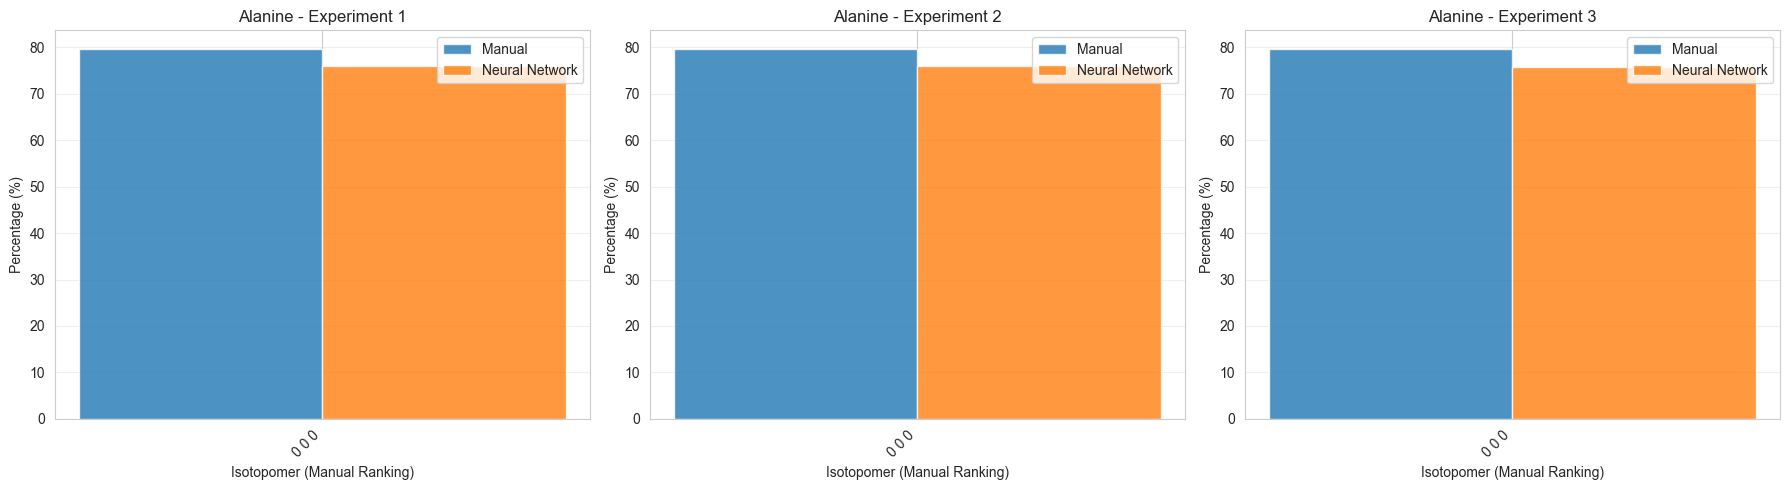

In [18]:
if alanine_comparison:
    plot_comparison('Alanine', alanine_comparison)

### 5.2 Plot Lactate Comparison

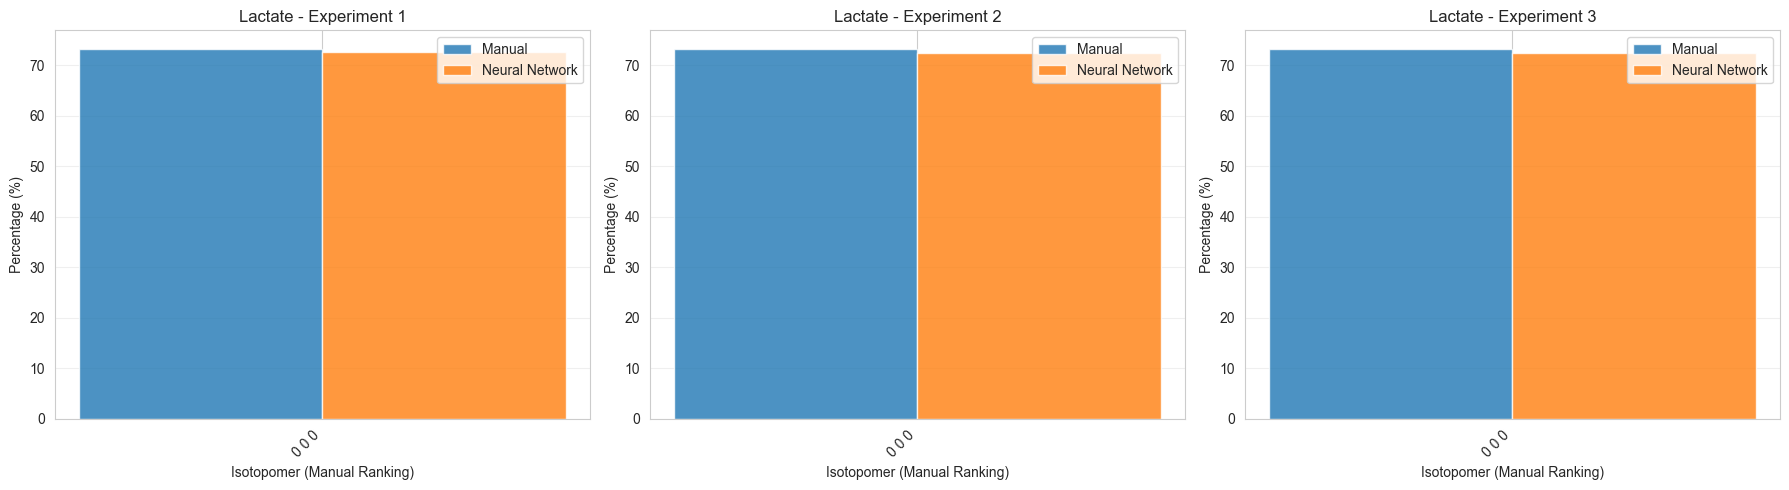

In [19]:
if lactate_comparison:
    plot_comparison('Lactate', lactate_comparison)

## 6. Summary and Conclusions

### Summary Statistics

In [20]:
summary = []

for metabolite_name, config in METABOLITES.items():
    manual_name = config['manual_name']
    nn_available = all_nn_results[metabolite_name] is not None
    manual_available = manual_name in manual_results
    
    summary.append({
        'Metabolite': metabolite_name,
        'Manual Name': manual_name,
        'NN Results': '✓' if nn_available else '✗',
        'Manual Results': '✓' if manual_available else '✗',
        'Comparison': '✓' if (nn_available and manual_available) else '✗'
    })

summary_df = pd.DataFrame(summary)
print("\nAnalysis Summary:")
display(summary_df)

print("\nNext Steps:")
print("1. For Aspartate and Glutamate: Train neural network models")
print("2. Improve isotopomer mapping between NN predictions and manual results")
print("3. Calculate quantitative metrics (RMSE, correlation, etc.)")
print("4. Statistical significance testing")


Analysis Summary:


,Metabolite,Manual Name,NN Results,Manual Results,Comparison
0,L-Alanine,Alanine,✓,✓,✓
1,L-LacticAcid,Lactate,✓,✓,✓
2,L-AsparticAcid,Aspartate,✗,✓,✗
3,L-GlutamicAcid,Glutamate,✗,✓,✗



Next Steps:
1. For Aspartate and Glutamate: Train neural network models
2. Improve isotopomer mapping between NN predictions and manual results
3. Calculate quantitative metrics (RMSE, correlation, etc.)
4. Statistical significance testing


## 7. Export Results

Save the comparison results to Excel files for further analysis.

In [21]:
# Create output directory
output_dir = 'comparison_results'
os.makedirs(output_dir, exist_ok=True)

# Save summary
summary_df.to_excel(os.path.join(output_dir, 'analysis_summary.xlsx'), index=False)
print(f"Summary saved to {output_dir}/analysis_summary.xlsx")

# Save detailed comparisons (implement as needed)
print("\nComparison results ready for publication preparation.")

Summary saved to comparison_results/analysis_summary.xlsx

Comparison results ready for publication preparation.
